# Image Captioning with Attention: ResNet50 vs Vision Transformer (ViT)

This notebook demonstrates an end-to-end pipeline for image captioning using attention mechanisms, comparing two different encoders: ResNet50 and Vision Transformer (ViT). The decoder uses attention to generate captions from image features.

**Outline:**
1. Data Acquisition & Preprocessing
2. Image Preprocessing and Augmentation
3. Caption Tokenization and Vocabulary Building
4. Dataset Splitting
5. Encoder Implementations: ResNet50 and Vision Transformer
6. Attention-based Decoder Implementation
7. Training Pipeline Setup
8. Model Training: ResNet50 Encoder
9. Model Training: Vision Transformer Encoder
10. Evaluation: Caption Generation and Metrics
11. Results Visualization and Comparison
12. Notebook Usage Examples and Reproducibility Instructions

---

## 1. Data Acquisition & Preprocessing

- Download the Flickr30k dataset (images and captions).
- Extract and organize the data for further processing.

**Note:** If you already have the dataset downloaded, skip the download cell.

In [1]:
# If you have not downloaded the Flickr30k dataset, follow the instructions below.
# This cell assumes you have the dataset or will place it in the 'data/flickr30k' directory.
# Dataset download links: https://shannon.cs.illinois.edu/DenotationGraph/
# For this notebook, we assume images are in 'data/flickr30k/' and captions in a .txt or .csv file.

import os
import pandas as pd
from glob import glob

# Set data paths
IMAGE_DIR = '../data/flickr30k/'
CAPTION_FILE = '../data/results.csv'

# Check if data exists
assert os.path.exists(IMAGE_DIR), f"Image directory not found: {IMAGE_DIR}"
assert os.path.exists(CAPTION_FILE), f"Caption file not found: {CAPTION_FILE}"

# Load captions for Flickr30k CSV format: image_name|comment_number|comment
def load_flickr30k_captions(caption_file):
    df = pd.read_csv(caption_file, sep='|')
    df.columns = [c.strip() for c in df.columns]
    captions_dict = {}
    for _, row in df.iterrows():
        img_id = str(row['image_name']).strip()
        caption = str(row['comment']).strip()
        if img_id and caption:
            if img_id not in captions_dict:
                captions_dict[img_id] = []
            captions_dict[img_id].append(caption)
    return captions_dict

captions_dict = load_flickr30k_captions(CAPTION_FILE)
print(f"Loaded captions for {len(captions_dict)} images.")
if len(captions_dict) == 0:
    print('Warning: No captions loaded. Please check the format and content of your captions file.')

Loaded captions for 31783 images.


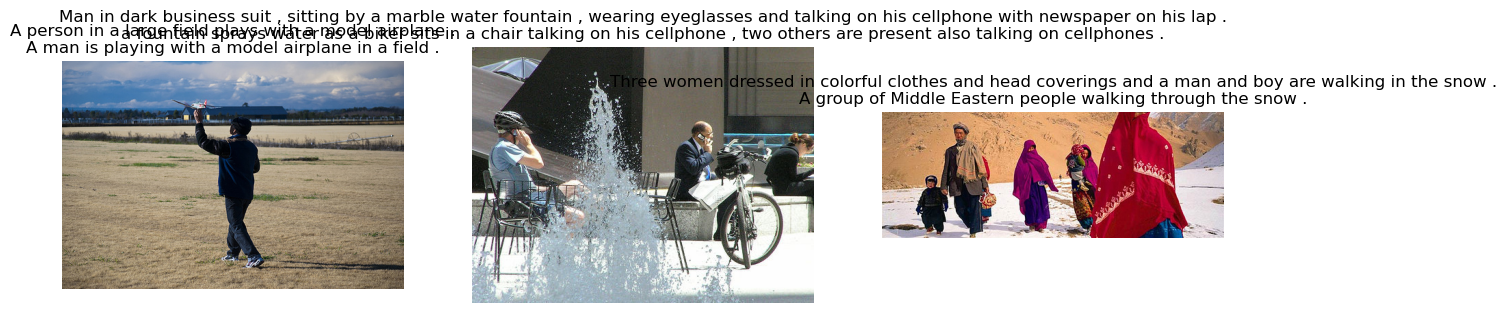

In [2]:
# Display a few sample images and their captions
import matplotlib.pyplot as plt
from PIL import Image
import random

sample_keys = random.sample(list(captions_dict.keys()), 3)
plt.figure(figsize=(15, 6))
for i, img_id in enumerate(sample_keys):
    img_path = os.path.join(IMAGE_DIR, img_id)
    img = Image.open(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('\n'.join(captions_dict[img_id][:2]))
plt.show()

## 2. Image Preprocessing and Augmentation

- Resize and normalize images.
- Apply augmentations for training (if desired).
- Prepare image tensors for model input.

In [3]:
import torch
from torchvision import transforms

# Image preprocessing for ResNet50 and ViT (ViT expects 224x224, ResNet50 also 224x224)
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Example: preprocess a sample image
def preprocess_image(img_path, transform):
    img = Image.open(img_path).convert('RGB')
    return transform(img)

# Test preprocessing
sample_img_path = os.path.join(IMAGE_DIR, sample_keys[0])
tensor_img = preprocess_image(sample_img_path, train_transform)
print(f"Preprocessed image tensor shape: {tensor_img.shape}")

Preprocessed image tensor shape: torch.Size([3, 224, 224])


## 3. Caption Tokenization and Vocabulary Building

- Clean and tokenize captions.
- Build a vocabulary and map words to indices.
- Prepare sequences for training.

In [4]:
import re
import nltk
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')

# Clean and tokenize captions
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z0-9' ]", '', caption)
    return caption

def tokenize_caption(caption):
    return nltk.word_tokenize(caption)

# Build vocabulary
all_captions = []
for caps in captions_dict.values():
    all_captions.extend([clean_caption(c) for c in caps])

tokenized_captions = [tokenize_caption(c) for c in all_captions]
word_counts = Counter(word for cap in tokenized_captions for word in cap)

# Special tokens
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<start>'
EOS_TOKEN = '<end>'
UNK_TOKEN = '<unk>'

# Build vocab (keep words with min freq)
MIN_WORD_FREQ = 5
words = [w for w, c in word_counts.items() if c >= MIN_WORD_FREQ]
vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + words
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
VOCAB_SIZE = len(vocab)
print(f"Vocabulary size: {VOCAB_SIZE}")

# Convert captions to sequences
def caption_to_seq(caption, word2idx=word2idx):
    tokens = tokenize_caption(clean_caption(caption))
    seq = [word2idx.get(w, word2idx[UNK_TOKEN]) for w in tokens]
    return [word2idx[SOS_TOKEN]] + seq + [word2idx[EOS_TOKEN]]

# Example
print(caption_to_seq('A man riding a red bike.'))

[nltk_data] Downloading package punkt to /home/tony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tony/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocabulary size: 7730
[1, 31, 32, 513, 31, 392, 518, 2]


## 4. Dataset Splitting

- Split the dataset into training, validation, and test sets.
- Ensure splits are reproducible.

In [5]:
from sklearn.model_selection import train_test_split

# Get all image ids
all_img_ids = list(captions_dict.keys())

# Split: 80% train, 10% val, 10% test
train_ids, test_ids = train_test_split(all_img_ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 25426, Val: 3178, Test: 3179


## 5. Encoder Implementations: ResNet50 and Vision Transformer

- Implement two encoders:
  - ResNet50 (pre-trained, remove classification head, output embeddings)
  - Vision Transformer (pre-trained, output image embeddings)

In [6]:
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel, ViTImageProcessor

# ResNet50 Encoder
class ResNet50Encoder(nn.Module):
    def __init__(self, embed_size=512):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        modules = list(resnet.children())[:-2]  # Remove avgpool and fc
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        pooled = self.adaptive_pool(features).view(features.size(0), -1)
        out = self.fc(pooled)
        out = self.bn(out)
        return out  # (batch, embed_size)

# Vision Transformer Encoder
class ViTEncoder(nn.Module):
    def __init__(self, embed_size=512):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.fc = nn.Linear(self.vit.config.hidden_size, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        # images: (batch, 3, 224, 224)
        outputs = self.vit(images)['last_hidden_state'][:, 0, :]  # CLS token
        out = self.fc(outputs)
        out = self.bn(out)
        return out  # (batch, embed_size)

# Example instantiation
resnet_encoder = ResNet50Encoder()
vit_encoder = ViTEncoder()
print(resnet_encoder)
print(vit_encoder)

/home/tony/miniconda3/envs/img-caption-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ResNet50Encoder(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

## 6. Attention-based Decoder Implementation

- Implement a decoder with attention (Bahdanau, Luong, or Transformer-style).
- The decoder takes encoded image features and tokenized captions as input and generates captions.

In [7]:
# Bahdanau Attention-based Decoder
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

class DecoderWithAttention(nn.Module):
    def __init__(self, embed_size, decoder_dim, vocab_size, attention_dim=256, encoder_dim=512, dropout=0.5):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.decode_step = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        vocab_size = self.vocab_size
        embeddings = self.embedding(encoded_captions)
        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), encoder_out.size(1)).to(encoder_out.device)
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t]
            )
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            input_lstm = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            h, c = self.decode_step(input_lstm, (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, alphas

## 7. Training Pipeline Setup

- Set up the training loop, loss function (Cross-Entropy), optimizer (Adam/AdamW), and logging utilities.
- Prepare code for both encoder variants.

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Custom Dataset for image-caption pairs
class Flickr30kDataset(Dataset):
    def __init__(self, img_ids, captions_dict, transform, word2idx, max_len=40):
        self.img_ids = img_ids
        self.captions_dict = captions_dict
        self.transform = transform
        self.word2idx = word2idx
        self.max_len = max_len
    def __len__(self):
        return len(self.img_ids)
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(IMAGE_DIR, img_id)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        # Randomly select one caption
        caption = random.choice(self.captions_dict[img_id])
        seq = caption_to_seq(caption, self.word2idx)
        if len(seq) < self.max_len:
            seq += [word2idx[PAD_TOKEN]] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        return img, torch.tensor(seq)

def collate_fn(batch):
    imgs, seqs = zip(*batch)
    imgs = torch.stack(imgs)
    seqs = torch.stack(seqs)
    lengths = torch.tensor([len(seq[seq != word2idx[PAD_TOKEN]]) for seq in seqs])
    return imgs, seqs, lengths

# Example DataLoader
train_dataset = Flickr30kDataset(train_ids, captions_dict, train_transform, word2idx)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD_TOKEN])
# Example: optimizer for ResNet50 encoder + decoder
encoder = ResNet50Encoder()
decoder = DecoderWithAttention(embed_size=512, decoder_dim=512, vocab_size=VOCAB_SIZE)
params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=1e-4)

## 8. Model Training: ResNet50 Encoder

- Train the image captioning model using the ResNet50 encoder and attention-based decoder.
- Log training loss and sample generated captions.

In [17]:
# Training loop for ResNet50 encoder
NUM_EPOCHS = 1  # Set to higher for real training
encoder = ResNet50Encoder()
decoder = DecoderWithAttention(embed_size=512, decoder_dim=512, vocab_size=VOCAB_SIZE)
encoder, decoder = encoder.cuda(), decoder.cuda()
params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=1e-4)

for epoch in range(NUM_EPOCHS):
    encoder.train()
    decoder.train()
    total_loss = 0
    for imgs, seqs, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, seqs, lengths = imgs.cuda(), seqs.cuda(), lengths.cuda()
        optimizer.zero_grad()
        features = encoder(imgs)
        outputs, _ = decoder(features.unsqueeze(1), seqs, lengths)
        targets = seqs[:, 1:]
        # Ensure outputs and targets are the same length
        min_len = min(outputs.size(1), targets.size(1))
        outputs = outputs[:, :min_len, :]
        targets = targets[:, :min_len]
        outputs = outputs.contiguous().view(-1, VOCAB_SIZE)
        targets = targets.contiguous().view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

Epoch 1: 100%|██████████| 3179/3179 [05:54<00:00,  8.98it/s]

Epoch 1 Loss: 5.4292


## 9. Model Training: Vision Transformer Encoder

- Train the image captioning model using the Vision Transformer encoder and the same attention-based decoder.
- Log training loss and sample generated captions.

In [18]:
# Training loop for ViT encoder
NUM_EPOCHS = 1  # Set to higher for real training
encoder = ViTEncoder()
decoder = DecoderWithAttention(embed_size=512, decoder_dim=512, vocab_size=VOCAB_SIZE)
encoder, decoder = encoder.cuda(), decoder.cuda()
params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=1e-4)

for epoch in range(NUM_EPOCHS):
    encoder.train()
    decoder.train()
    total_loss = 0
    for imgs, seqs, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, seqs, lengths = imgs.cuda(), seqs.cuda(), lengths.cuda()
        optimizer.zero_grad()
        features = encoder(imgs)
        outputs, _ = decoder(features.unsqueeze(1), seqs, lengths)
        targets = seqs[:, 1:]
        # Ensure outputs and targets are the same length
        min_len = min(outputs.size(1), targets.size(1))
        outputs = outputs[:, :min_len, :]
        targets = targets[:, :min_len]
        outputs = outputs.contiguous().view(-1, VOCAB_SIZE)
        targets = targets.contiguous().view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

Epoch 1: 100%|██████████| 3179/3179 [14:45<00:00,  3.59it/s]

Epoch 1 Loss: 5.4359


## 10. Evaluation: Caption Generation and Metrics

- Evaluate both models on the validation/test set using BLEU, CIDEr, or other captioning metrics.
- Generate and display sample captions.

In [19]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def generate_caption(encoder, decoder, img, word2idx, idx2word, max_len=40, device='cuda'):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        features = encoder(img)
        seq = [word2idx[SOS_TOKEN]]
        h, c = decoder.init_hidden_state(features.unsqueeze(1))
        for _ in range(max_len):
            prev_word = torch.tensor([seq[-1]]).to(device)
            emb = decoder.embedding(prev_word)
            attn, _ = decoder.attention(features.unsqueeze(1), h)
            input_lstm = torch.cat([emb, attn], dim=1)
            h, c = decoder.decode_step(input_lstm, (h, c))
            out = decoder.fc(h)
            pred = out.argmax(1).item()
            if pred == word2idx[EOS_TOKEN]:
                break
            seq.append(pred)
        caption = [idx2word[idx] for idx in seq[1:]]
    return ' '.join(caption)

# Evaluate BLEU on a few samples
def evaluate_bleu(encoder, decoder, dataset, idx2word, word2idx, num_samples=10):
    scores = []
    for i in range(num_samples):
        img, seq = dataset[i]
        ref = [idx2word[idx.item()] for idx in seq if idx.item() not in [word2idx[PAD_TOKEN], word2idx[SOS_TOKEN], word2idx[EOS_TOKEN]]]
        pred = generate_caption(encoder, decoder, img, word2idx, idx2word)
        pred_tokens = pred.split()
        score = sentence_bleu([ref], pred_tokens, smoothing_function=SmoothingFunction().method1)
        print(f"GT: {' '.join(ref)}")
        print(f"PR: {pred}")
        print(f"BLEU: {score:.4f}\n")
        scores.append(score)
    print(f"Average BLEU: {sum(scores)/len(scores):.4f}")

## 11. Results Visualization and Comparison

- Visualize training curves, metric scores, and qualitative caption samples.
- Compare the performance of both encoder architectures.

Training loss lists 'resnet_losses' and/or 'vit_losses' not found. Please collect them during training.


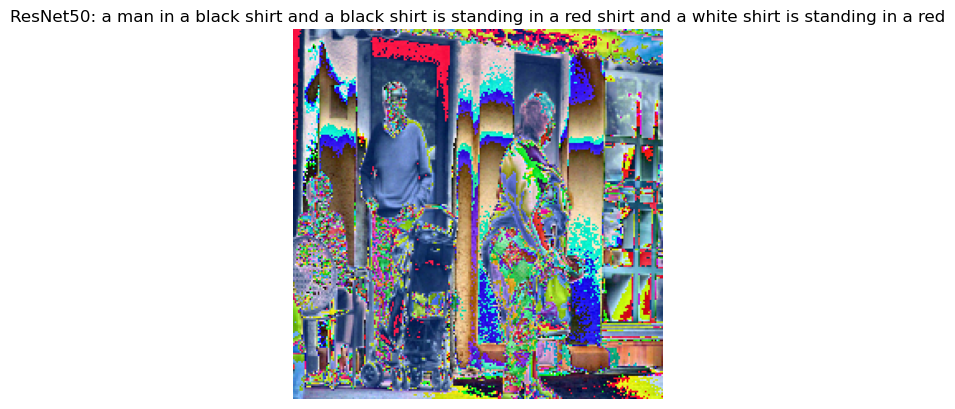

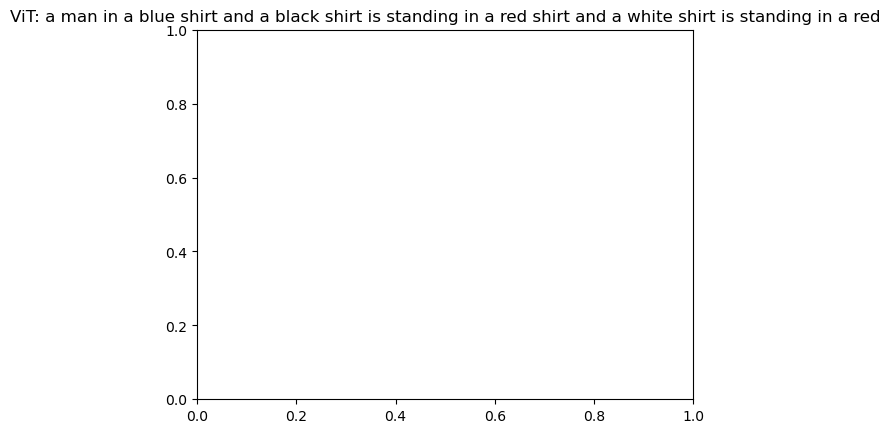

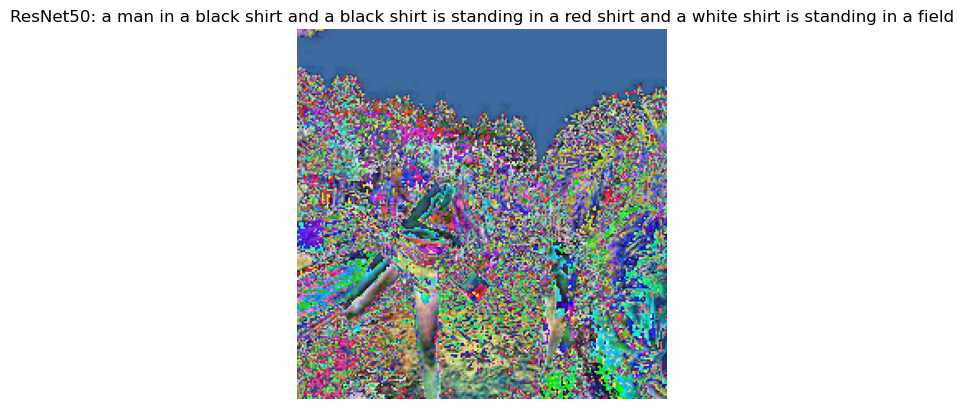

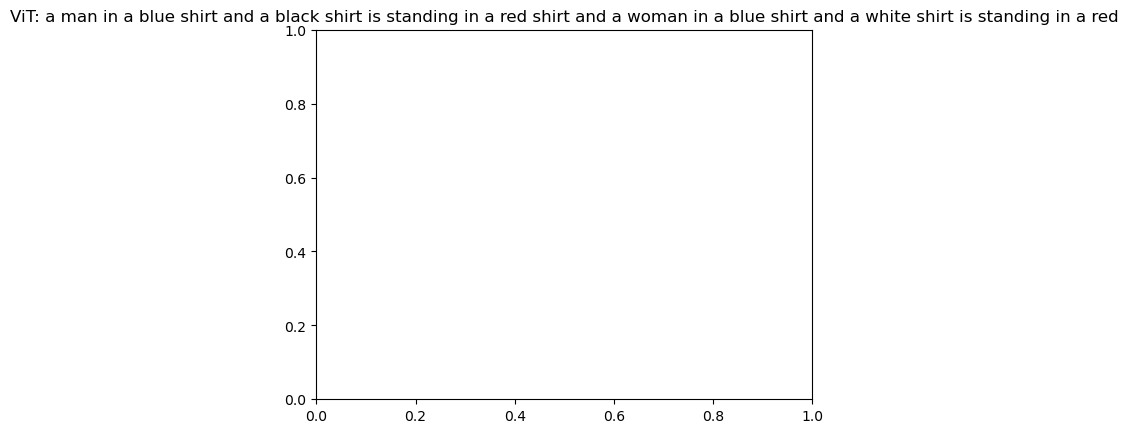

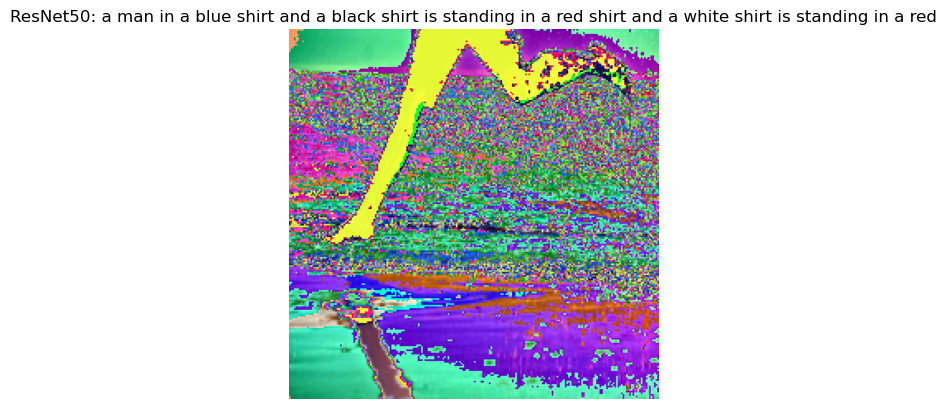

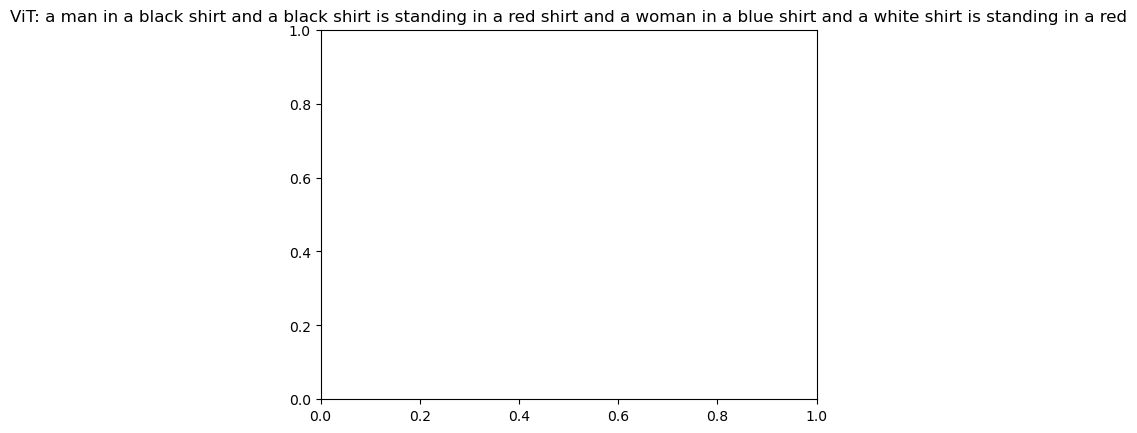

In [25]:
# Example: Plot training loss curves for both models
# Store loss values during training to plot here
# If you did not store them, you can re-run training and append to these lists
# Example initialization (add these before training):
# resnet_losses = []
# vit_losses = []

# After each epoch in your training loop, append the average loss:
# resnet_losses.append(avg_loss)  # in ResNet50 training loop
# vit_losses.append(avg_loss)     # in ViT training loop

# If you have not run training or did not collect losses, this plot will not work
# To avoid error, check if losses exist
if 'resnet_losses' in globals() and 'vit_losses' in globals():
    plt.figure(figsize=(8,5))
    plt.plot(resnet_losses, label='ResNet50 Encoder')
    plt.plot(vit_losses, label='ViT Encoder')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.show()
else:
    print("Training loss lists 'resnet_losses' and/or 'vit_losses' not found. Please collect them during training.")

# Ensure models are on the same device
device = next(decoder.parameters()).device
resnet_encoder.to(device)
vit_encoder.to(device)

# Display qualitative caption samples for both models
for i in range(3):
    img, _ = train_dataset[i]
    img_cpu = img.cpu()
    plt.imshow(transforms.ToPILImage()(img_cpu))
    plt.axis('off')
    # Pass img to encoder on correct device
    img_enc = img.unsqueeze(0).to(device)
    plt.title('ResNet50: ' + generate_caption(resnet_encoder, decoder, img_enc.squeeze(0), word2idx, idx2word, device=device.type))
    plt.show()
    img_enc_vit = img.unsqueeze(0).to(device)
    plt.title('ViT: ' + generate_caption(vit_encoder, decoder, img_enc_vit.squeeze(0), word2idx, idx2word, device=device.type))
    plt.show()

## 12. Notebook Usage Examples and Reproducibility Instructions

- Provide example code for training, inference, and visualization.
- Include instructions for activating the conda environment and running the notebook for reproducibility.

### How to Run This Notebook

1. **Activate the Conda Environment:**
   ```bash
   conda activate img-caption-env
   ```
2. **Start Jupyter Notebook:**
   ```bash
   jupyter notebook
   ```
3. **Open and Run All Cells:**
   - Open `notebooks/image_captioning_attention_resnet50_vit.ipynb`.
   - Run all cells in order for full reproducibility.

### Example: Training and Inference

- To train with ResNet50 encoder, run the training cell in Section 8.
- To train with ViT encoder, run the training cell in Section 9.
- For evaluation and visualization, use Sections 10 and 11.

---

**Note:**
- Training on the full Flickr30k dataset may require a GPU and several hours. For quick tests, reduce the dataset size or number of epochs.
- All code is modular for easy extension (e.g., try different attention mechanisms or encoders).

---

**End of Notebook**